# Notebook 2
In this notebook lets analyze the geographic distribution of listings and explore what this might mean in terms of the gentrification status of neighborhoods. 

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import bs4
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd

# Import CSV
We need to bring in the csv files with the lat longs from the last notebook. 

In [2]:
east_holly = pd.read_csv('/Users/saratohamy/Desktop/University/Grad School/UCLA/Spring 2021 Quarter/UP229 – Urban Data Science/Group Project/eho_clist_df.csv')
ktown = pd.read_csv('/Users/saratohamy/Desktop/University/Grad School/UCLA/Spring 2021 Quarter/UP229 – Urban Data Science/Group Project/ktown_df.csv')
hpark = pd.read_csv('/Users/saratohamy/Desktop/University/Grad School/UCLA/Spring 2021 Quarter/UP229 – Urban Data Science/Group Project/hpark_df.csv')
bheights = pd.read_csv('/Users/saratohamy/Desktop/University/Grad School/UCLA/Spring 2021 Quarter/UP229 – Urban Data Science/Group Project/bheights_df.csv')

In [10]:
print(east_holly.shape)
print(ktown.shape)
print(hpark.shape)
print(bheights.shape)

(789, 10)
(1080, 10)
(662, 10)
(346, 10)


# Mapping
Lets start by taking a look at the geographic distribution of these listings for each neighborhood

In [3]:
# put all the dataframes into a geodataframe for mapping
eholly_gdf= gpd.GeoDataFrame(
    east_holly, geometry=gpd.points_from_xy(east_holly.lon, east_holly.lat))
ktown_gdf= gpd.GeoDataFrame(
    ktown, geometry=gpd.points_from_xy(ktown.lon, ktown.lat))
hpark_gdf= gpd.GeoDataFrame(
    hpark, geometry=gpd.points_from_xy(hpark.lon, hpark.lat))
bheights_gdf= gpd.GeoDataFrame(
    bheights, geometry=gpd.points_from_xy(bheights.lon, bheights.lat))

In [4]:
# make sure the lat longs are in the right projection
eholly_gdf = eholly_gdf.set_crs("EPSG:4326")
ktown_gdf = ktown_gdf.set_crs("EPSG:4326")
hpark_gdf = hpark_gdf.set_crs("EPSG:4326")
bheights_gdf = bheights_gdf.set_crs("EPSG:4326")

## East Hollywood

(-118.6270998, -117.6227602, 33.76960865, 35.723018350000004)

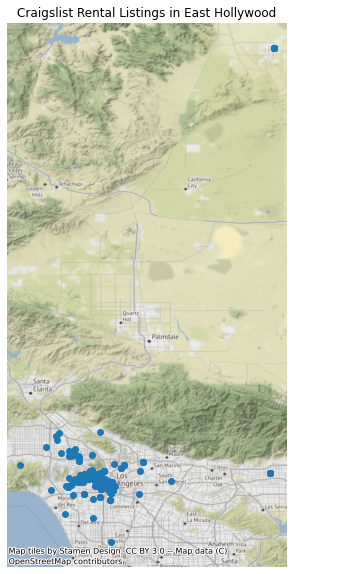

In [13]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
eholly_gdf.plot(ax=ax,)
ctx.add_basemap(ax, crs=eholly_gdf.crs)
ax.set_facecolor('k')
plt.title("Craigslist Rental Listings in East Hollywood")
plt.axis('off')

## Koreatown

(-118.3906627, -118.19951130000001, 33.718643900000004, 34.153674099999996)

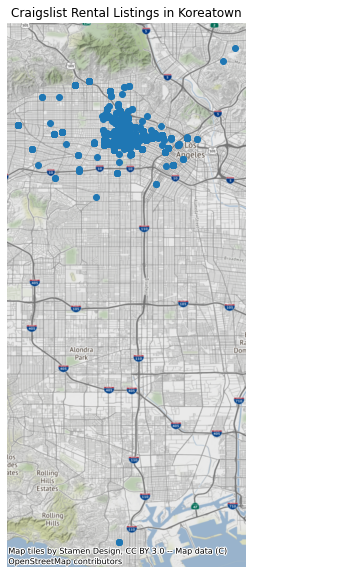

In [14]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
ktown_gdf.plot(ax=ax,)
ctx.add_basemap(ax, crs=ktown_gdf.crs) # thought I'd choose a different (default) basemap, but I know the one in the example below is Stamen Toner Lite
ax.set_facecolor('k')
plt.title("Craigslist Rental Listings in Koreatown")
plt.axis('off')

## Highland Park

(-118.52221730000001, -116.8674367, 33.838042200000004, 34.285913799999996)

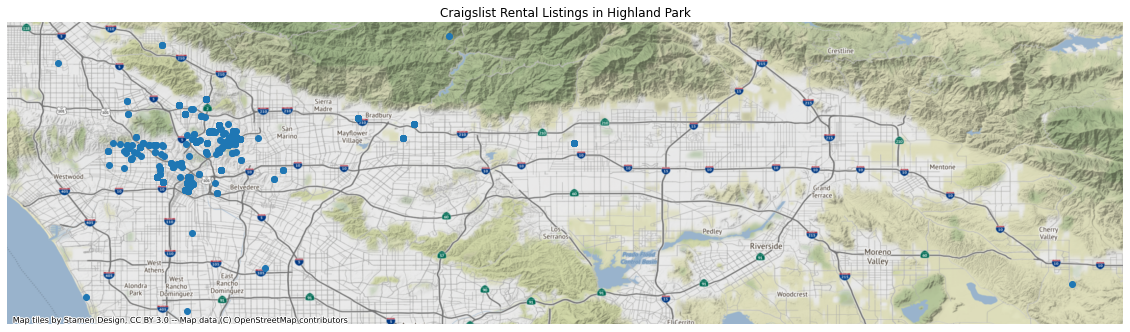

In [12]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
hpark_gdf.plot(ax=ax,)
ctx.add_basemap(ax, crs=hpark_gdf.crs) # thought I'd choose a different (default) basemap, but I know the one in the example below is Stamen Toner Lite
ax.set_facecolor('k')
plt.title("Craigslist Rental Listings in Highland Park")
plt.axis('off')

## Boyle Heights

(-118.376525, -117.854575, 33.6915739, 34.761744099999994)

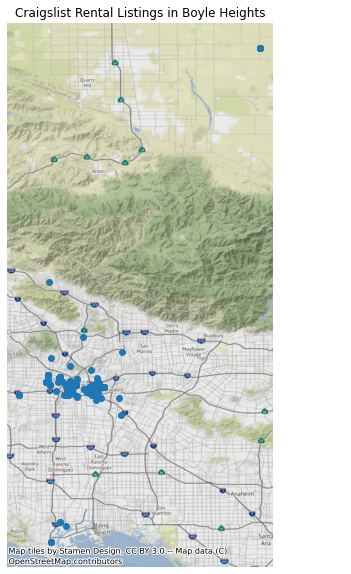

In [13]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
bheights_gdf.plot(ax=ax,)
ctx.add_basemap(ax, crs=bheights_gdf.crs) # thought I'd choose a different (default) basemap, but I know the one in the example below is Stamen Toner Lite
ax.set_facecolor('k')
plt.title("Craigslist Rental Listings in Boyle Heights")
plt.axis('off')

# Map with colored dots for code words and neighborhood shapefiles
In this section, we take a look at each individual description for every listing and see if it contains one of the code words. We then map the listings, and color code them based on whether they mention a code word or not. We also bring in neighborhood boundary polygons and drop those listings that are outside of the polygons. Finally, we compare the number of listings that mention a code words between dataframes with listings within neighborhood boundaries and those without a geographic boundary. 

In [5]:
# define our code words in a list
g_codes = ['private', 'amenities','lounge', 'luxury','luxurious','gated','unique','modern','prime','bars','restaurants', 'safe','walk','walking','walkable', 'security', 'vegan','gluten', 'private', 'security', 'lounge', 'luxury', 'gated', 'modern', 'prime', 'central', 'downtown', 'walking', 'accessible', 'charming', 'quirky', 'unique', 'quaint', 'coming', 'authentic', 'restaurants', 'culture', 'cultural', 'foodies', 'diverse', 'character', 'vibe', 'hip', 'dense', 'cool,' 'funky', 'landmark', 'historic', 'vegan', 'gluten', 'art', 'bars', 'beer', 'stadium', 'preserved', 'outdoors', 'affordable', 'upscale', 'leisure', 'budget', 'vegan', 'gluten', 'art', 'bars', 'beer', 'stadium', 'preserved', 'outdoors']

In [6]:
import re

In [7]:
# bring in neighborhood shapefiles
nbhood = gpd.read_file('cfbcc20d-2c5d-4c30-9dfa-627d46ec1a742020328-1-9ulknm.pzqsm.shp')
nbhood.head()

,OBJECTID,name,geometry
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0..."
1,2,Arleta,"POLYGON ((-118.44255 34.26412, -118.44240 34.2..."
2,3,Arlington Heights,"POLYGON ((-118.31862 34.05306, -118.31673 34.0..."
3,4,Atwater Village,"MULTIPOLYGON (((-118.27886 34.15321, -118.2788..."
4,5,Baldwin Hills/Crenshaw,"POLYGON ((-118.36102 34.02532, -118.36026 34.0..."


In [8]:
# identify the individual neighborhood shapefiles and save into its own variable
eholly_shp = nbhood.loc[nbhood['name'] == 'East Hollywood']
ktown_shp = nbhood.loc[nbhood['name'] == 'Koreatown']
hpark_shp = nbhood.loc[nbhood['name'] == 'Highland Park']
bheights_shp = nbhood.loc[nbhood['name'] == 'Boyle Heights']

## East Hollywood

In [9]:
# make the descriptions lower case since the code words are all lower case
eholly_gdf['Description'] = eholly_gdf.Description.str.lower()

In [10]:
# lets extract one of the code words if present in the description so that we can create a boolean column based on whether the description has at least one code word
# code from https://stackoverflow.com/questions/55028465/python-searching-a-string-within-a-dataframe-from-a-list
eholly_gdf['code_words'] = eholly_gdf.Description.str.extract('({0})'.format('|'.join(g_codes)), flags=re.IGNORECASE)
result = eholly_gdf[~pd.isna(eholly_gdf.code_words)]

print(result)

     Unnamed: 0                                         Post Title  \
0             0  Renovated East Hollywood Gem! 1BD/1BA with in ...   
1             1                      Cozy Studio in East Hollywood   
2             2          East Hollywood Apartment 1 Bedroom 1 Bath   
3             3            East Hollywood Spanish Studio Remodeled   
4             4        East Hollywood Spanish Studio ALL UTILIITES   
..          ...                                                ...   
784         784  **453 Spring St #321-DTLA: Creative Office Spa...   
785         785  Retail Auto Dealer Office Space & Car Spot (Tu...   
786         786  Retail Auto Dealer Office & Car Space [TurnKey...   
787         787  Used Car Dealer Office & Retail Auto Dealer Sp...   
788         788  Retail Auto Dealer Lot Office & Used Car Spot|...   

                                           Description  \
0    <section id="postingbody">\n<div class="print-...   
1    <section id="postingbody">\n<div class

In [30]:
eholly_gdf.tail()

,Unnamed: 0,Post Title,Description,Neighborhood,Price,No. Beds,SF,URL,lat,lon,geometry,code_words
784,784,**453 Spring St #321-DTLA: Creative Office Spa...,"<section id=""postingbody"">\n<div class=""print-...",(Los Angeles),$663,NaN,241.0,https://losangeles.craigslist.org/lac/off/d/lo...,34.048116,-118.24895,POINT (-118.24895 34.04812),downtown
785,785,Retail Auto Dealer Office Space & Car Spot (Tu...,"<section id=""postingbody"">\n<div class=""print-...",NaN,$0,NaN,NaN,https://losangeles.craigslist.org/lac/off/d/lo...,34.076600,-118.26460,POINT (-118.26460 34.07660),gated
786,786,Retail Auto Dealer Office & Car Space [TurnKey...,"<section id=""postingbody"">\n<div class=""print-...",NaN,$0,NaN,NaN,https://losangeles.craigslist.org/lac/off/d/lo...,34.049300,-118.29170,POINT (-118.29170 34.04930),gated
787,787,Used Car Dealer Office & Retail Auto Dealer Sp...,"<section id=""postingbody"">\n<div class=""print-...",NaN,$0,NaN,NaN,https://losangeles.craigslist.org/lac/off/d/lo...,34.049300,-118.29170,POINT (-118.29170 34.04930),gated
788,788,Retail Auto Dealer Lot Office & Used Car Spot|...,"<section id=""postingbody"">\n<div class=""print-...",NaN,$0,NaN,NaN,https://losangeles.craigslist.org/lac/off/d/lo...,34.049300,-118.29170,POINT (-118.29170 34.04930),gated


In [11]:
import numpy as np

In [12]:
# assign a boolean to each row based on whether the description has a code word
eholly_gdf["cw_present"] = eholly_gdf["code_words"].apply(lambda x: True if x in g_codes else False)
eholly_gdf

,Unnamed: 0,Post Title,Description,Neighborhood,Price,No. Beds,SF,URL,lat,lon,geometry,code_words,cw_present
0,0,Renovated East Hollywood Gem! 1BD/1BA with in ...,"<section id=""postingbody"">\n<div class=""print-...",(East Hollywood),"$2,095",1.0,850.0,https://losangeles.craigslist.org/lac/apa/d/lo...,34.088924,-118.303436,POINT (-118.30344 34.08892),art,True
1,1,Cozy Studio in East Hollywood,"<section id=""postingbody"">\n<div class=""print-...",(Los Angeles),"$1,495",NaN,450.0,https://losangeles.craigslist.org/lac/apa/d/lo...,34.094440,-118.296209,POINT (-118.29621 34.09444),restaurants,True
2,2,East Hollywood Apartment 1 Bedroom 1 Bath,"<section id=""postingbody"">\n<div class=""print-...","(5154 Fountain Ave - 5154 1/4 Los Angeles, CA)","$1,550",1.0,NaN,https://losangeles.craigslist.org/lac/apa/d/lo...,34.090000,-118.294400,POINT (-118.29440 34.09000),art,True
3,3,East Hollywood Spanish Studio Remodeled,"<section id=""postingbody"">\n<div class=""print-...",(Los Angeles),"$1,295",NaN,440.0,https://losangeles.craigslist.org/lac/apa/d/lo...,34.088891,-118.302097,POINT (-118.30210 34.08889),art,True
4,4,East Hollywood Spanish Studio ALL UTILIITES,"<section id=""postingbody"">\n<div class=""print-...",(East Hollywood),"$1,495",NaN,475.0,https://losangeles.craigslist.org/lac/apa/d/lo...,34.091419,-118.297529,POINT (-118.29753 34.09142),art,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,784,**453 Spring St #321-DTLA: Creative Office Spa...,"<section id=""postingbody"">\n<div class=""print-...",(Los Angeles),$663,NaN,241.0,https://losangeles.craigslist.org/lac/off/d/lo...,34.048116,-118.248950,POINT (-118.24895 34.04812),downtown,True
785,785,Retail Auto Dealer Office Space & Car Spot (Tu...,"<section id=""postingbody"">\n<div class=""print-...",NaN,$0,NaN,NaN,https://losangeles.craigslist.org/lac/off/d/lo...,34.076600,-118.264600,POINT (-118.26460 34.07660),gated,True
786,786,Retail Auto Dealer Office & Car Space [TurnKey...,"<section id=""postingbody"">\n<div class=""print-...",NaN,$0,NaN,NaN,https://losangeles.craigslist.org/lac/off/d/lo...,34.049300,-118.291700,POINT (-118.29170 34.04930),gated,True
787,787,Used Car Dealer Office & Retail Auto Dealer Sp...,"<section id=""postingbody"">\n<div class=""print-...",NaN,$0,NaN,NaN,https://losangeles.craigslist.org/lac/off/d/lo...,34.049300,-118.291700,POINT (-118.29170 34.04930),gated,True


In [13]:
eholly_gdf.to_csv('eholly_cwpresent.csv')

[]

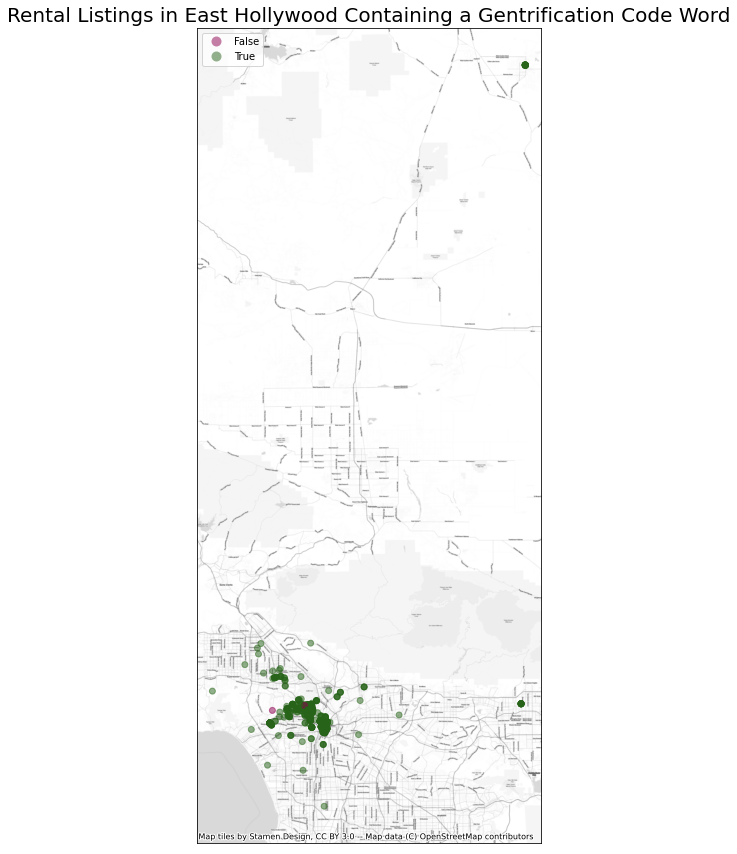

In [13]:
# map it!
# keep alpha relatively low so that we can see any overlapping points/listings
fig, ax = plt.subplots(figsize=(15,15))
eholly_gdf.to_crs('EPSG:3857').plot('cw_present', cmap='PiYG', categorical= True, legend=True, ax=ax, alpha=0.5)

legend = ax.get_legend()

ctx.add_basemap(ax, zoom=12, source=ctx.providers.Stamen.TonerLite)
ax.set_title('Rental Listings in East Hollywood Containing a Gentrification Code Word', fontsize=20)                           
ax.set_xticks([])
ax.set_yticks([])

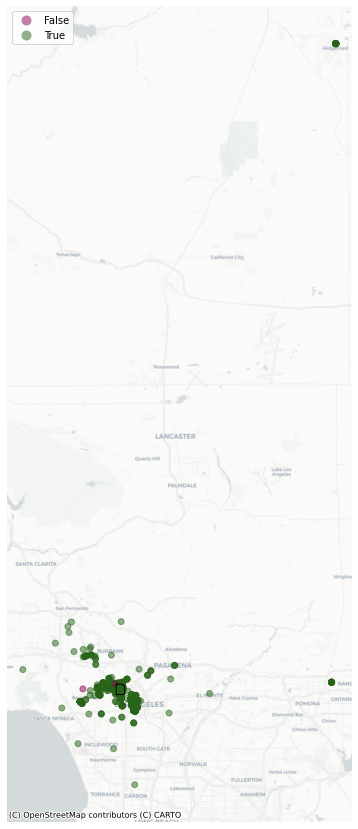

In [14]:
# set up the plot canvas with plt.subplots
fig, ax = plt.subplots(figsize=(15, 15))


# listings
eholly_gdf.to_crs('EPSG:3857').plot('cw_present', cmap='PiYG', categorical= True, legend=True, ax=ax, alpha=0.5)


# neighborhood boundaries
eholly_shp.to_crs('EPSG:3857').plot(ax=ax,  
        facecolor='none', 
        edgecolor='black',
        alpha=1)


# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)

This doesn't really tell us much, so lets drop the listings that are not within the polygon and map them for a closer look. 

In [59]:
# bring in relevant packages
import shapely.speedups
shapely.speedups.enable()

In [19]:
eholly_shp

,OBJECTID,name,geometry
25,26,East Hollywood,"POLYGON ((-118.28740 34.09836, -118.28740 34.0..."


In [20]:
# code from https://automating-gis-processes.github.io/CSC18/lessons/L4/point-in-polygon.html
pip_mask = eholly_gdf.within(eholly_shp.loc[25, 'geometry'])

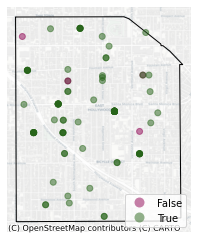

In [22]:
# code from https://automating-gis-processes.github.io/CSC18/lessons/L4/point-in-polygon.html
pip_data = eholly_gdf.loc[pip_mask]
fig, ax = plt.subplots()

# neighborhood boundaries
eholly_shp.to_crs('EPSG:3857').plot(ax=ax,  
        facecolor='none', 
        edgecolor='black',
        alpha=1)

pip_data.to_crs('EPSG:3857').plot('cw_present', cmap='PiYG', categorical= True, legend=True, ax=ax, alpha=0.5)

plt.tight_layout()
# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)


In [24]:
eholly_within = pip_data

In [33]:
eholly_within.shape

(102, 13)

In [25]:
# SAVE CSV FOR FUTURE USE
eholly_within.to_csv('eholly_within.csv')

### Compare the number of non-code word listings across the two dataframes

In [73]:
eholly_gdf.shape

(789, 13)

In [62]:
eholly_gdf.loc[eholly_gdf['cw_present']==False].shape

(6, 13)

In [74]:
eholly_within.shape

(102, 13)

In [64]:
eholly_within.loc[eholly_within['cw_present']==False].shape

(4, 13)

13% of the listings under the East Hollywood page on Craigslist actually lie within the neighborhood boundaries of East Hollywood. And 4/6 of the listings in East Hollywood that do not have gentrification code words mentioned in their descriptions lie within the neighborhood boundaries. 

## Koreatown

[]

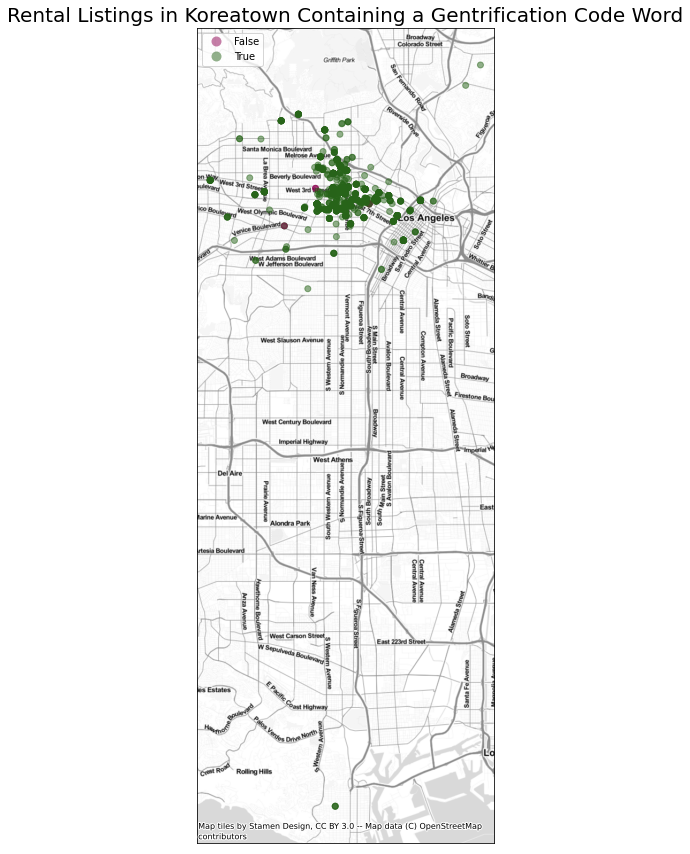

In [14]:
ktown_gdf['Description'] = ktown_gdf.Description.str.lower()
ktown_gdf['code_words'] = ktown_gdf.Description.str.extract('({0})'.format('|'.join(g_codes)), flags=re.IGNORECASE)
ktown_gdf["cw_present"] = ktown_gdf["code_words"].apply(lambda x: True if x in g_codes else False)
fig, ax = plt.subplots(figsize=(15,15))
ktown_gdf.to_crs('EPSG:3857').plot('cw_present', cmap='PiYG', categorical= True, legend=True, ax=ax, alpha=0.5)


# all this is the same as before
legend = ax.get_legend()

ctx.add_basemap(ax, zoom=12, source=ctx.providers.Stamen.TonerLite)
ax.set_title('Rental Listings in Koreatown Containing a Gentrification Code Word', fontsize=20)                           
ax.set_xticks([])
ax.set_yticks([])

In [15]:
ktown_gdf.to_csv('ktown_cwpresent.csv')

In [26]:
ktown_shp

,OBJECTID,name,geometry
52,53,Koreatown,"POLYGON ((-118.28785 34.06182, -118.28783 34.0..."


In [27]:
 pip_mask = ktown_gdf.within(ktown_shp.loc[52, 'geometry'])

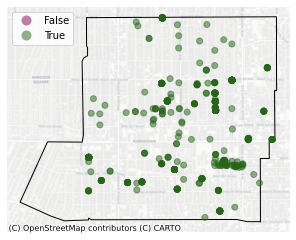

In [30]:
pip_data = ktown_gdf.loc[pip_mask]
fig, ax = plt.subplots()

# neighborhood boundaries
ktown_shp.to_crs('EPSG:3857').plot(ax=ax,  
        facecolor='none', 
        edgecolor='black',
        alpha=1)

pip_data.to_crs('EPSG:3857').plot('cw_present', cmap='PiYG', categorical= True, legend=True, ax=ax, alpha=0.5)

plt.tight_layout()
# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)


In [34]:
ktown_within = pip_data
# SAVE CSV FILE FOR FUTURE USE
ktown_within.to_csv('ktown_within.csv')

In [35]:
ktown_within.shape

(570, 13)

### Compare the number of non-code word listings across the two dataframes

In [71]:
ktown_gdf.shape

(1080, 13)

In [65]:
ktown_gdf.loc[ktown_gdf['cw_present']==False].shape

(8, 13)

In [72]:
ktown_within.shape

(570, 13)

In [66]:
ktown_within.loc[ktown_within['cw_present']==False].shape

(2, 13)

53% of the listings under the Koreatown page on Craigslist actually lie within the neighborhood boundaries of Koreatown. And 2/8 of the listings in Koreatown that do not have gentrification code words mentioned in their descriptions lie within the neighborhood boundaries. 

## Highland Park

[]

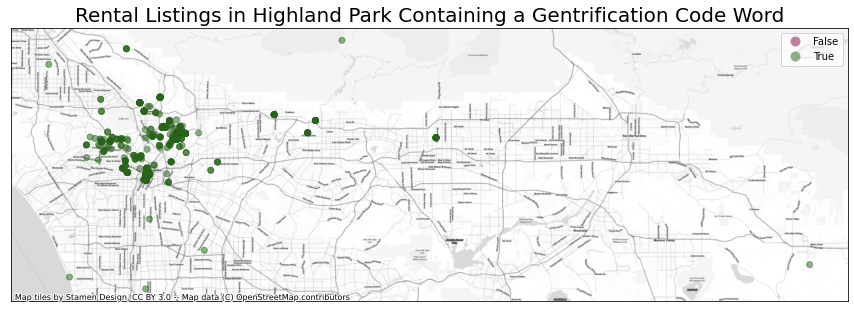

In [16]:
hpark_gdf['Description'] = hpark_gdf.Description.str.lower()
hpark_gdf['code_words'] = hpark_gdf.Description.str.extract('({0})'.format('|'.join(g_codes)), flags=re.IGNORECASE)
hpark_gdf["cw_present"] = hpark_gdf["code_words"].apply(lambda x: True if x in g_codes else False)
fig, ax = plt.subplots(figsize=(15,15))
hpark_gdf.to_crs('EPSG:3857').plot('cw_present', cmap='PiYG', categorical= True, legend=True, ax=ax, alpha=0.5)


# all this is the same as before
legend = ax.get_legend()

ctx.add_basemap(ax, zoom=12, source=ctx.providers.Stamen.TonerLite)
ax.set_title('Rental Listings in Highland Park Containing a Gentrification Code Word', fontsize=20)                           
ax.set_xticks([])
ax.set_yticks([])

In [17]:
hpark_gdf.to_csv('hpark_cwpresent.csv')

In [36]:
hpark_shp

,OBJECTID,name,geometry
45,46,Highland Park,"POLYGON ((-118.18914 34.13184, -118.18744 34.1..."


In [55]:
 pip_mask = hpark_gdf.within(hpark_shp.loc[45, 'geometry'])

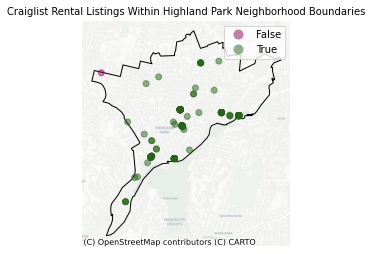

In [56]:
pip_data = hpark_gdf.loc[pip_mask]
fig, ax = plt.subplots()

# neighborhood boundaries
hpark_shp.to_crs('EPSG:3857').plot(ax=ax,  
        facecolor='none', 
        edgecolor='black',
        alpha=1)

pip_data.to_crs('EPSG:3857').plot('cw_present', cmap='PiYG', categorical= True, legend=True, ax=ax, alpha=0.5)

plt.tight_layout()
# no axis
ax.axis('off')

# set title
ax.set_title('Craiglist Rental Listings Within Highland Park Neighborhood Boundaries', fontsize=10)  
# add a basemap
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)



In [57]:
hpark_within = pip_data
# SAVE CSV FILE FOR FUTURE USE
hpark_within.to_csv('hpark_within.csv')

In [58]:
hpark_within.shape

(216, 13)

### Compare the number of non-code word listings across the two dataframes

In [69]:
hpark_gdf.shape

(662, 13)

In [67]:
hpark_gdf.loc[hpark_gdf['cw_present']==False].shape

(7, 13)

In [70]:
hpark_within.shape

(216, 13)

In [68]:
hpark_within.loc[hpark_within['cw_present']==False].shape

(7, 13)

32% of the listings under the Highland Park page on Craigslist actually lie within the neighborhood boundaries of Highland Park. And 7/7 of the listings in Highland Park that do not have gentrification code words mentioned in their descriptions lie within the neighborhood boundaries. 

## Boyle Heights

[]

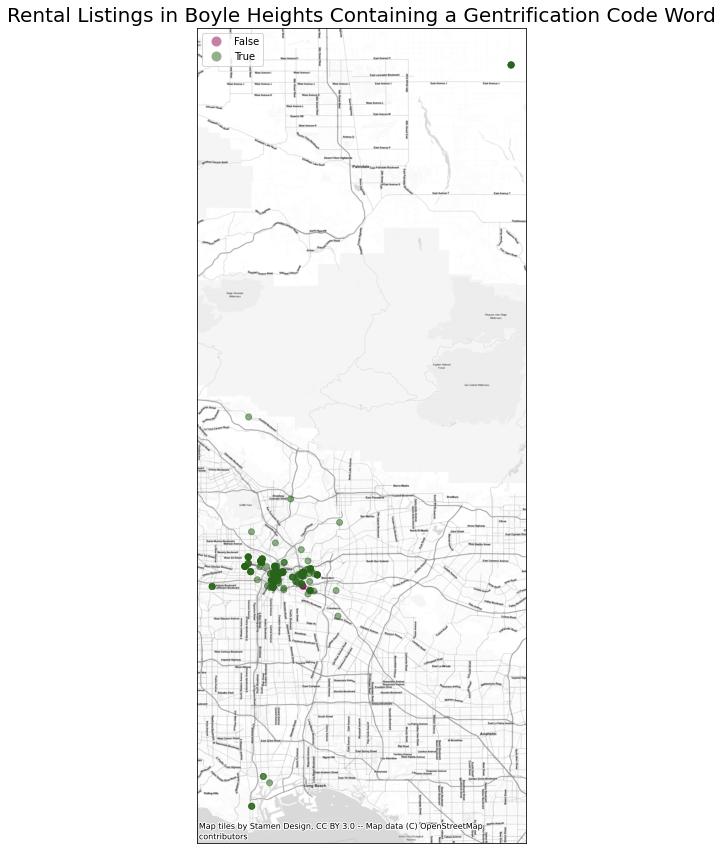

In [18]:
bheights_gdf['Description'] = bheights_gdf.Description.str.lower()
bheights_gdf['code_words'] = bheights_gdf.Description.str.extract('({0})'.format('|'.join(g_codes)), flags=re.IGNORECASE)
bheights_gdf["cw_present"] = bheights_gdf["code_words"].apply(lambda x: True if x in g_codes else False)
fig, ax = plt.subplots(figsize=(15,15))
bheights_gdf.to_crs('EPSG:3857').plot('cw_present', cmap='PiYG', categorical= True, legend=True, ax=ax, alpha=0.5)


# all this is the same as before
legend = ax.get_legend()

ctx.add_basemap(ax, zoom=12, source=ctx.providers.Stamen.TonerLite)
ax.set_title('Rental Listings in Boyle Heights Containing a Gentrification Code Word', fontsize=20)                           
ax.set_xticks([])
ax.set_yticks([])

In [19]:
bheights_gdf.to_csv('bheights_cwpresent.csv')

In [49]:
bheights_shp

,OBJECTID,name,geometry
9,10,Boyle Heights,"POLYGON ((-118.19263 34.06077, -118.19260 34.0..."


In [50]:
 pip_mask = bheights_gdf.within(bheights_shp.loc[9, 'geometry'])

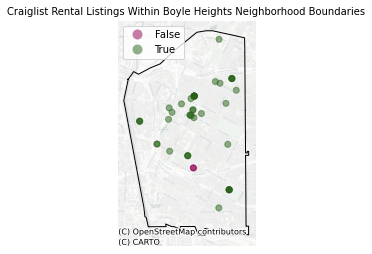

In [51]:
pip_data = bheights_gdf.loc[pip_mask]
fig, ax = plt.subplots()

# neighborhood boundaries
bheights_shp.to_crs('EPSG:3857').plot(ax=ax,  
        facecolor='none', 
        edgecolor='black',
        alpha=1)

pip_data.to_crs('EPSG:3857').plot('cw_present', cmap='PiYG', categorical= True, legend=True, ax=ax, alpha=0.5)

plt.tight_layout()
# no axis
ax.axis('off')

# set title
ax.set_title('Craiglist Rental Listings Within Boyle Heights Neighborhood Boundaries', fontsize=10)  
# add a basemap
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)



In [54]:
bheights_within = pip_data
# SAVE CSV FILE FOR FUTURE USE
bheights_within.to_csv('bheights_within.csv')

In [53]:
bheights_within.shape

(47, 13)

### Compare the number of non-code word listings across the two dataframes

In [75]:
bheights_gdf.shape

(346, 13)

In [76]:
bheights_gdf.loc[bheights_gdf['cw_present']==False].shape

(5, 13)

In [77]:
bheights_within.shape

(47, 13)

In [78]:
bheights_within.loc[bheights_within['cw_present']==False].shape

(4, 13)

14% of the listings under the Boyle Heights page on Craigslist actually lie within the neighborhood boundaries of Boyle Heights. And 4/5 of the listings in Boyle Heights that do not have gentrification code words mentioned in their descriptions lie within the neighborhood boundaries. 

# Findings from Notebook 2

Mapping out the rental listings in each neighborhood revealed that the geographic location of many listings was actually far from the actual neighborhood under which it was listed. We found that East Hollywood had the highest percent, 87 percent, of its listings not actually located within the neighborhood boundaries. Koreatown had the lowest with 47 percent. Reasons for listings being located outside of the labeled neighborhood range from human error, to wanting to list properties under "trendy" neighborhoods to increase the chances of a successful listing, to not lack of knowledge on the extent of neighborhood boundaries. The second of these reasons could potentially serve as an indicator of gentrification itself. If the second rason holds true, then theoretically neighborhoods with a higher percentage of listings existing outside of the neighborhood boundary could be more gentrified than those with lower a percentage. Again, this works off the assumption that properties are being falsely listed under neighborhoods due to their "trendiness," which could be due to ongoing or completed gentrification. However, proving this is out of the scope of this project.

We also found that each neighborhood has a number of listings that mention none of our identified gentrification code words. When we looked at this variable within neighborhood boundaries, we found that Koreatown had the lowest number (2/8 or 25%) of postings without gentrification code words within its neighborhood boundary, while Highland Park had the highest (7/7 or 100%). A high number of non-code word postings could also support the theory that properties falsely listed under a neighborhood are done so to benefit from the trendiness of a neighborhood, especially if the property itself is not "trendy."

In the next notebook, we'll see how our findings from the last two notebooks interact with rental prices and whether rental prices vary with code word frequencies and property location. 